Este código es parte de una implementación de un modelo de red neuronal usando Keras para clasificar dígitos del conjunto de datos MNIST. Aquí está el desglose de cada bloque de código en detalle.

1. Importación de Bibliotecas y Configuración de la Semilla Aleatoria

Se importan varias bibliotecas necesarias:

- numpy para manipulación de arreglos y datos.
- matplotlib.pyplot para visualización de datos (si se requiere).
- os para configuraciones del entorno.
- keras y keras_tuner, bibliotecas de alto nivel para construir y entrenar redes neuronales.

## Carga del Conjunto de Datos MNIST

`keras.utils.set_random_seed(23)`

Aquí se establece una semilla aleatoria para los generadores aleatorios en Keras. Esto garantiza que los resultados sean reproducibles; en este caso, la semilla está fijada en 23, de manera que si se vuelve a ejecutar este código, los resultados serán los mismos cada vez.

`(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()`

El conjunto de datos MNIST contiene imágenes de dígitos escritos a mano (del 0 al 9) en escala de grises. Este código carga los datos en cuatro conjuntos:

- x_train_val y y_train_val: Datos de entrada y etiquetas para entrenamiento y validación combinados.
- x_test y y_test: Datos de entrada y etiquetas para pruebas.

El conjunto `x_train_val` contiene imágenes de entrenamiento y validación combinadas, que luego se dividirán en subconjuntos más adelante en el código.

## Preprocesamiento de los datos

Las imágenes originales en MNIST son de 28x28 píxeles (784 píxeles en total).

``` python
input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
```

- La dimensión input_dim se establece en 784 para que cada imagen se convierta en un vector unidimensional de longitud 784.
- reshape(-1, input_dim): Cambia la forma de cada imagen 28x28 a un vector de 784 valores, adecuado para un modelo de red neuronal densa.
- astype("float32") / 255.0: Convierte los valores de enteros (0 a 255) a flotantes (0.0 a 1.0) dividiendo por 255. Esto normaliza los datos, lo cual es beneficioso para el entrenamiento de redes neuronales.

```python
num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
```

Se define num_classes como 10 porque hay 10 clases (dígitos del 0 al 9).
to_categorical convierte las etiquetas (por ejemplo, el número 5) en etiquetas categóricas o one-hot encoded (por ejemplo, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]). Esto transforma las etiquetas para que sean compatibles con la salida del modelo en la clasificación.

```python
x_train = x_train_val[:-10000]
x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]
y_val = y_train_val[-10000:]
```

Este código divide el conjunto x_train_val en dos partes:

- x_train: La mayor parte de los datos para el entrenamiento.
- x_val: Los últimos 10,000 ejemplos de x_train_val se utilizan para validación.

La validación es importante para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento. Las etiquetas correspondientes (y_train y y_val) se dividen de la misma manera.

**Keras Tuner es una biblioteca de código abierto desarrollada para ajustar automáticamente los hiperparámetros de modelos de redes neuronales en Keras. Los hiperparámetros son configuraciones del modelo que afectan su rendimiento, como el número de capas, el tamaño de las capas, la tasa de aprendizaje, etc. Ajustar estos hiperparámetros manualmente puede ser tedioso y consumir mucho tiempo, por lo que Keras Tuner facilita esta tarea mediante técnicas de búsqueda como búsqueda aleatoria, búsqueda en hiperband y optimizaciones bayesianas.**


In [1]:
# Import necessary libraries and set seed
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import keras_tuner

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
keras.utils.set_random_seed(23)

# Load MNIST dataset
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess data
input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Train-validation split
x_train = x_train_val[:-10000]
x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]
y_val = y_train_val[-10000:]


2024-11-15 00:27:30.644867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731626850.657519  461628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731626850.661296  461628 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 00:27:30.673623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Este código utiliza Keras Tuner para optimizar los hiperparámetros de un modelo de red neuronal para clasificar dígitos en el conjunto de datos MNIST. A continuación, se explica cada sección del código.

## Definición del Espacio de Búsqueda para la Arquitectura del Modelo

La función `build_model(hp)` define la arquitectura del modelo y el espacio de búsqueda de hiperparámetros.

- Argumento hp: Es un objeto proporcionado por Keras Tuner para definir los valores de los hiperparámetros, permitiendo la exploración de diferentes configuraciones.

- Crea un modelo secuencial y define la capa de entrada con una dimensión de 784, adecuada para el conjunto de datos MNIST (28x28 píxeles aplanados).

```python
for L in range(hp.Int("num_layers", 1, 3)):
    M.add(keras.layers.Dense(
        units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=100),
        activation='relu'))
```

- Bucle de Capas Ocultas: Permite que el modelo tenga entre 1 y 3 capas ocultas.
  - Para cada capa, se define el número de unidades en un rango de 700 a 900, con incrementos de 100 (700, 800, o 900). Este número de unidades se selecciona mediante hp.Int, que explora diferentes opciones en el espacio de búsqueda.
  - La función de activación `relu` se utiliza para cada capa oculta, introduciendo no linealidad en el modelo.

Los valores máximos y mínimos indican cuántas neuronas como máximo y como mínimo puede tener cada capa.

```python
M.add(keras.layers.Dense(10, activation='softmax'))
M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
```

- Capa de Salida: Es una capa densa con 10 neuronas (una por cada clase de dígito), con softmax como función de activación para generar probabilidades de clasificación.

- Compilación del Modelo: Se usa categorical_crossentropy como función de pérdida (dado que es un problema de clasificación multicategoría), adam como optimizador, y se evalúa el modelo mediante la métrica de precisión (accuracy).

## Definición del Tuner con Optimización Bayesiana

```python
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp",
    project_name="MNIST"
)
```

El objeto tuner usa la clase BayesianOptimization para optimizar los hiperparámetros del modelo.

- hypermodel=build_model: Define el modelo a optimizar utilizando la función build_model.
- objective="val_accuracy": Optimiza los hiperparámetros para maximizar la precisión en el conjunto de validación (val_accuracy).
- max_trials=10: Realiza un máximo de 10 pruebas o configuraciones de hiperparámetros.
- executions_per_trial=1: Ejecuta una vez cada prueba.
- directory="/tmp" y project_name="MNIST": Almacena los resultados en un directorio temporal llamado tmp bajo el nombre de proyecto MNIST.

tuner.search_space_summary() -> muestra una línea de resumen de los hiperparámetros definidos en build_model.

**La optimización bayesiana es una técnica que selecciona inteligentemente los hiperparámetros basándose en el rendimiento de pruebas anteriores, en lugar de realizar búsquedas completamente aleatorias o exhaustivas. Esto permite una exploración más eficiente del espacio de hiperparámetros.**

In [2]:
# Define the search space for tuning the number of layers and units
def build_model(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(784,)))

    for L in range(hp.Int("num_layers", 1, 3)):
        M.add(keras.layers.Dense(
            units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=100),
            activation='relu'))

    M.add(keras.layers.Dense(10, activation='softmax'))
    M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return M

# Define the tuner using Bayesian Optimization
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp",
    project_name="MNIST"
)

# Display search space summary
tuner.search_space_summary()


I0000 00:00:1731629190.855885  461628 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 700, 'max_value': 900, 'step': 100, 'sampling': 'linear'}


This section of code performs the hyperparameter tuning, displays a summary of the tuning results, retrieves the best model found, and evaluates it on the test dataset. Here's a step-by-step explanation:

This line initiates the search for the best hyperparameters:

```python
tuner.search(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val))
```

- x_train and y_train are the training data and labels.
- batch_size=16: Sets the batch size, meaning the model will process 16 samples at a time before updating weights.
- epochs=10: Specifies that each model configuration will train for 10 epochs.
- validation_data=(x_val, y_val): The validation set (x_val, y_val) is used to evaluate each model configuration after each epoch. The model aims to maximize validation accuracy, which helps prevent overfitting.

tuner.get_best_models(num_models=1): Retrieves the best model found during the tuning process. num_models=1 specifies that only the single best-performing model should be returned.

In [3]:
# Perform the search for the best hyperparameters
tuner.search(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val))

# Display the results summary
tuner.results_summary(num_trials=1)

# Get the best model and evaluate it on the test data
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')


Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.9775000214576721

Best val_accuracy So Far: 0.9812999963760376
Total elapsed time: 00h 05m 43s
Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
num_layers: 1
units_0: 800
units_1: 800
units_2: 700
Score: 0.9812999963760376


/home/yassin/anaconda3/envs/per/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-11-15 01:27:09.414363: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45', 144 bytes spill stores, 144 bytes spill loads

2024-11-15 01:27:09.555293: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45', 512 bytes spill stores, 512 bytes spill loads



Loss: 0.1028
Precisión: 98.2%


This section of code retrains the model using the best hyperparameters identified during the tuning process on the combined train-validation dataset (x_train_val and y_train_val). The purpose of this retraining step is to fully leverage the available data, maximizing the model’s generalization before it is tested on unseen data. Here’s a detailed explanation:

```python
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(x_train_val, y_train_val, batch_size=16, epochs=10, verbose=0)
```


- x_train_val and y_train_val: The model is now trained on the entire combined train-validation set, maximizing the amount of data used for learning.

- batch_size=16: The batch size is set to 16, as specified in the tuning process.

- epochs=10: The model trains for 10 epochs.

- verbose=0: Setting this to 0 suppresses the output details for each epoch.

- Resulting H Object: The fit method returns a History object (H), which contains information about the training process, including loss and accuracy per epoch. This object can be useful if you wish to analyze the training dynamics or plot the learning curve.

In summary, this retraining step applies the best model configuration on the full train-validation set, ensuring the model has the best chance to learn from the maximum amount of data before evaluation on the test set.


Loss: 0.1118
Precisión: 97.7%


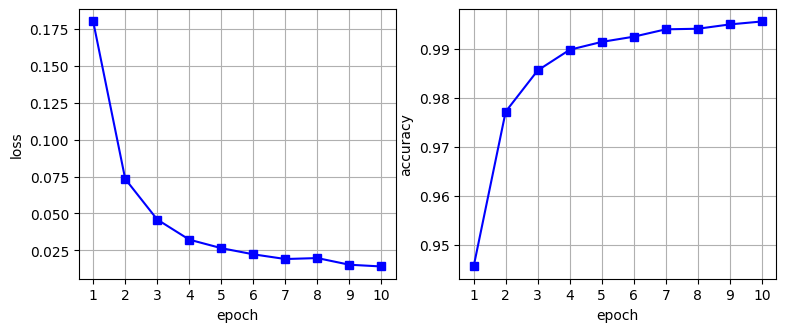

In [4]:
# Retrain the model using the best hyperparameters on the full train-validation set
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(x_train_val, y_train_val, batch_size=16, epochs=10, verbose=0)

# Plot training loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)

ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', marker='s')

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', marker='s')

# Evaluate on test set
score = M.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')
